# Predizione di vittoria nelle battaglie di pokémon
## Programmazione di Applicazioni Data intensive
Laurea di Ingegneria e Scienze Informatiche
### Partecipanti:
- Daniele Merighi
- Luca Palazzini
- Lore


# Librerie e import utilizzati

In [1]:
# Librerie base
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sb
import pandas as pd
from typing import Tuple

# Compatibilitá con Jupyter Notebook
%matplotlib inline

# Sklearn
import sklearn as skl
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor

# XGBoost
from xgboost import XGBClassifier

# Descrizione del problema
Il dataset preso da noi in considerazione, contiene dati riguardanti degli studenti, le loro situazioni accademiche, abitudini e status di salute mentale.

Il nostro obiettivo é quello di riuscire a predire il voto dell'esame finale in base ad alcune delle caratteristiche riguardo ad uno studente.

# Parte I - Analisi dei dati

## Caricamento dei dati

In [2]:
# Setup dei percorsi dei file dei dataset
dataset_base_path: str = './datasets/'
combat_file_path: str = dataset_base_path + '/combats.csv'
type_chart_file_path: str = dataset_base_path + '/type_chart.csv'
pokemon_file_path: str = dataset_base_path + '/pokemon.csv'
team_combat_file_path: str = dataset_base_path + '/team_combat.csv'
team_file_path: str = dataset_base_path + '/pokemon_id_each_team.csv'

In [3]:
# Caricamento dei vari dataframe del dataset
dataset_type_chart: pd.DataFrame = pd.read_csv(type_chart_file_path)
dataset_pokemon: pd.DataFrame = pd.read_csv(pokemon_file_path)
dataset_teams: pd.DataFrame = pd.read_csv(team_file_path)
dataset_combat: pd.DataFrame = pd.read_csv(combat_file_path)
dataset_team_combat: pd.DataFrame = pd.read_csv(team_combat_file_path)

In [4]:
# Settaggio degli id delle tabelle
dataset_pokemon.set_index('#', inplace=True)
dataset_teams.set_index('#', inplace=True)

In [5]:
# Join dei dataset per ottenere le informazioni sui combattimenti uno contro uno
dataset_1v1_fights: pd.DataFrame = dataset_combat \
    .join(dataset_pokemon, on="First_pokemon", how="inner", rsuffix=' First') \
    .join(dataset_pokemon, on="Second_pokemon", how="inner", rsuffix=' Second') \
    .drop(columns=["Name", "Name Second", "Generation", "Generation Second"])

In [6]:
# Stampa delle informazioni del dataset
dataset_1v1_fights.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   First_pokemon     50000 non-null  int64 
 1   Second_pokemon    50000 non-null  int64 
 2   Winner            50000 non-null  int64 
 3   Type 1            50000 non-null  object
 4   Type 2            25969 non-null  object
 5   HP                50000 non-null  int64 
 6   Attack            50000 non-null  int64 
 7   Defense           50000 non-null  int64 
 8   Sp. Atk           50000 non-null  int64 
 9   Sp. Def           50000 non-null  int64 
 10  Speed             50000 non-null  int64 
 11  Legendary         50000 non-null  bool  
 12  Type 1 Second     50000 non-null  object
 13  Type 2 Second     26015 non-null  object
 14  HP Second         50000 non-null  int64 
 15  Attack Second     50000 non-null  int64 
 16  Defense Second    50000 non-null  int64 
 17  Sp. Atk Seco

## Esplorazione dei dati

In [7]:
dataset_1v1_fights.describe()

,First_pokemon,Second_pokemon,Winner,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,HP Second,Attack Second,Defense Second,Sp. Atk Second,Sp. Def Second,Speed Second
count,50000.000000,50000.000000,50000.000000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,400.495640,403.159660,408.890100,69.06692,79.121040,74.248540,72.893900,72.077020,68.214420,69.099940,79.035100,74.148600,72.664220,72.018440,68.279220
std,229.549429,230.083644,231.159961,25.27720,32.690876,31.635322,32.745608,27.916398,29.288297,25.170108,32.413583,31.578308,32.644598,27.836053,29.108555
min,1.000000,1.000000,1.000000,1.00000,5.000000,5.000000,10.000000,20.000000,5.000000,1.000000,5.000000,5.000000,10.000000,20.000000,5.000000
25%,203.000000,207.000000,206.000000,50.00000,55.000000,50.000000,50.000000,50.000000,45.000000,50.000000,55.000000,50.000000,50.000000,50.000000,45.000000
50%,399.000000,402.000000,422.000000,65.00000,75.000000,70.000000,65.000000,70.000000,65.000000,65.000000,75.000000,70.000000,65.000000,70.000000,65.000000
75%,597.250000,602.000000,606.000000,80.00000,100.000000,90.000000,95.000000,90.000000,90.000000,80.000000,100.000000,90.000000,95.000000,90.000000,90.000000
max,800.000000,800.000000,800.000000,255.00000,190.000000,230.000000,194.000000,230.000000,180.000000,255.000000,190.000000,230.000000,194.000000,230.000000,180.000000


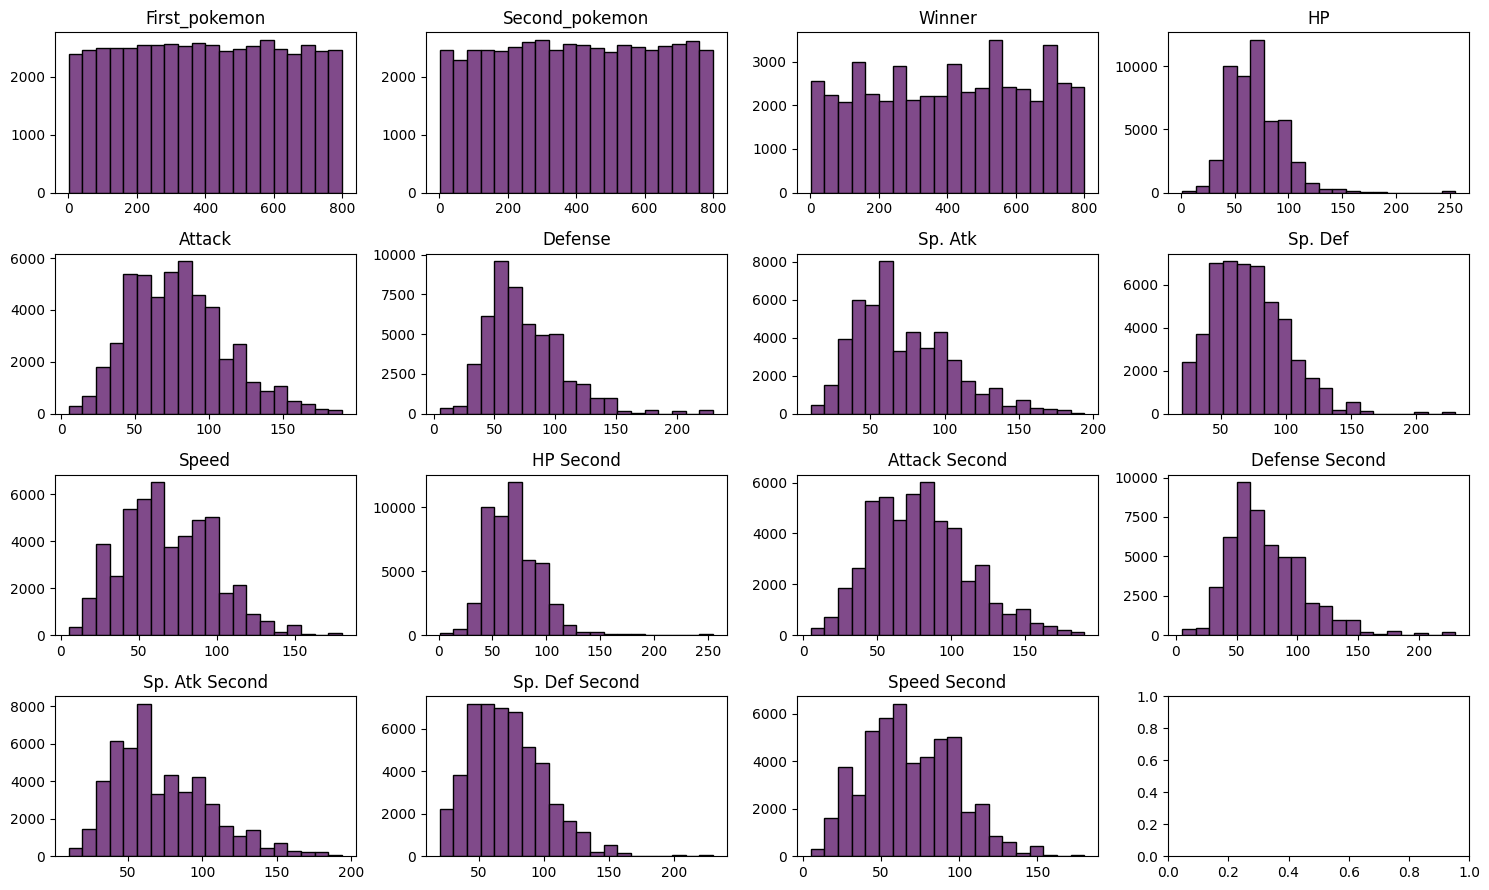

In [8]:
# Estraiamo i dati numerici dal dataframe
numerical_dataset: pd.DataFrame = dataset_1v1_fights.select_dtypes(include=np.number)

# Creiamo un bel color palette perché si
cmap: LinearSegmentedColormap = sb.diverging_palette(300, 60, s=50, l=40, as_cmap=True)
bar_color: Tuple[float, float, float, float] = cmap(0.0)

fig, axis = plt.subplots(4, 4, figsize=(15, 9))
axis = axis.flatten()
for i, label in enumerate(numerical_dataset.columns):
    axis[i].hist(numerical_dataset[label], bins=20, color=bar_color, edgecolor='black')
    axis[i].set_title(label)
fig.tight_layout()

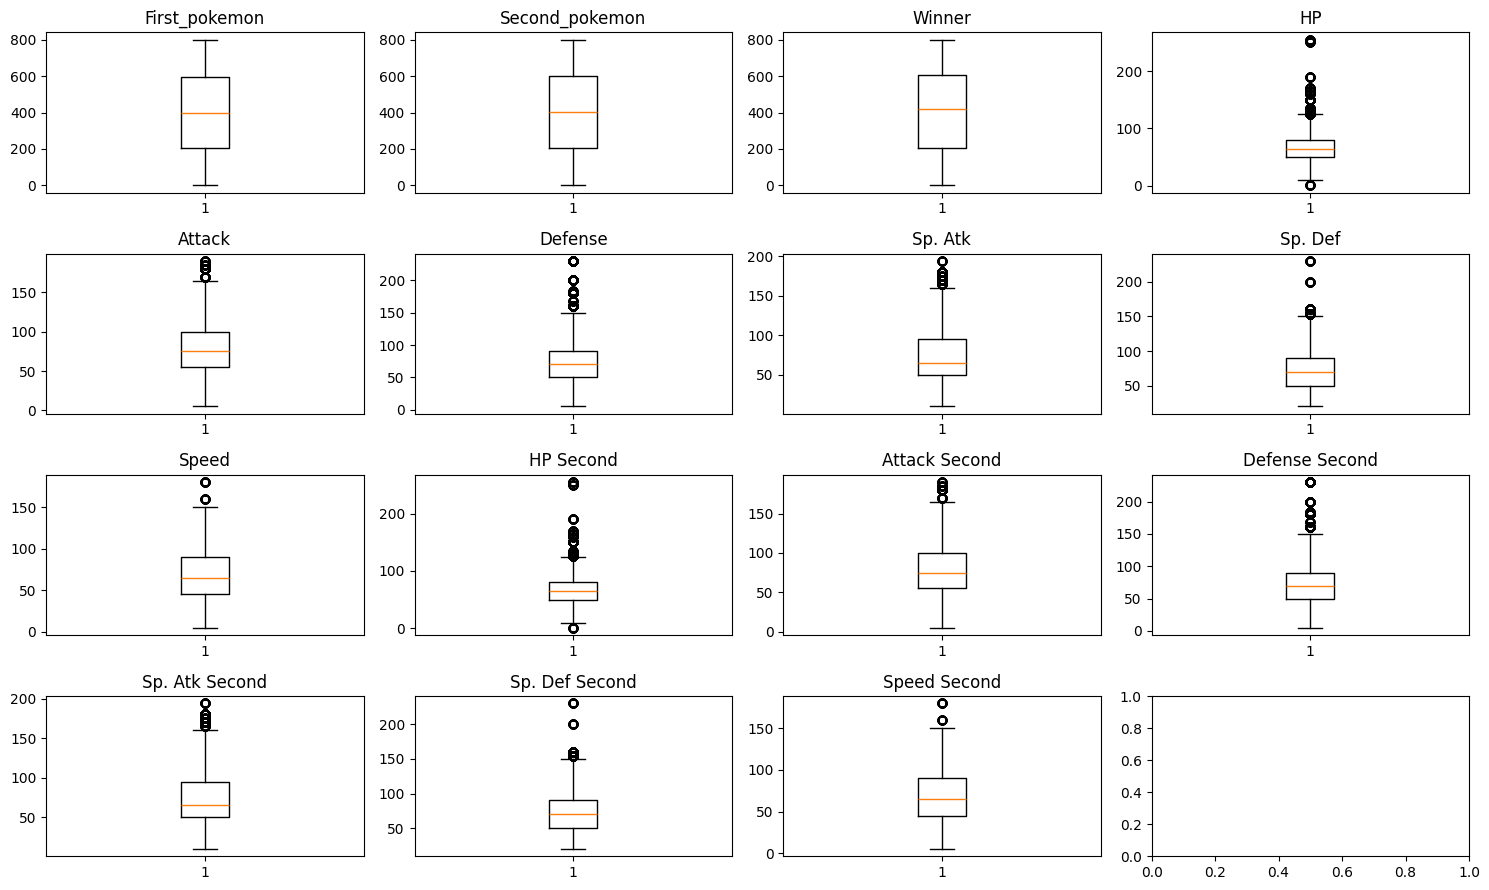

In [9]:
fig, axis = plt.subplots(4, 4, figsize=(15, 9))
axis = axis.flatten()
for i, label in enumerate(numerical_dataset.columns):
    axis[i].boxplot(numerical_dataset[label])
    axis[i].set_title(label)
fig.tight_layout()

## Codifica dei dati

In [10]:
# Rimpiazzo dei tipi NaN con None
dataset_1v1_without_nan: pd.DataFrame = dataset_1v1_fights.fillna('None')
type_chart_without_nan: pd.DataFrame = dataset_type_chart.fillna('None')

In [11]:
def get_dual_multiplier(df, atk_col, def1_col, def2_col, newcol):
   tmp = type_chart_without_nan.rename(columns={
      'attack':   atk_col,
      'defense1': def1_col,
      'defense2': def2_col
   })
   df = df.merge(
      tmp[[atk_col, def1_col, def2_col, 'multiplier']],
      on=[atk_col, def1_col, def2_col],
      how='left'
   ).rename(columns={'multiplier': newcol})
   df[newcol] = df[newcol].fillna(1.0)
   return df

dataset_1v1_multiplier = dataset_1v1_without_nan.copy()
dataset_1v1_multiplier = get_dual_multiplier(dataset_1v1_multiplier, 'Type 1', 'Type 1 Second', 'Type 2 Second', 'F1_to_S')
dataset_1v1_multiplier = get_dual_multiplier(dataset_1v1_multiplier, 'Type 2', 'Type 1 Second', 'Type 2 Second', 'F2_to_S')
dataset_1v1_multiplier = get_dual_multiplier(dataset_1v1_multiplier, 'Type 1 Second', 'Type 1', 'Type 2', 'S1_to_F')
dataset_1v1_multiplier = get_dual_multiplier(dataset_1v1_multiplier, 'Type 2 Second', 'Type 1', 'Type 2', 'S2_to_F')
dataset_1v1_multiplier.drop(columns=['Type 1', 'Type 2', 'Type 1 Second', 'Type 2 Second'], inplace=True)

In [12]:
# Rimpiazzo dell id del vincitore con 0 se vince il primo, 1 se vince il secondo
dataset_1v1_multiplier.loc[dataset_1v1_multiplier['Winner'] == dataset_1v1_multiplier['First_pokemon'], 'Winner'] = 0
dataset_1v1_multiplier.loc[dataset_1v1_multiplier['Winner'] == dataset_1v1_multiplier['Second_pokemon'], 'Winner'] = 1
dataset_1v1_multiplier.drop(columns=['First_pokemon', 'Second_pokemon'], inplace=True)

In [13]:
# Rimpiazzo delle statistiche con la differenza delle statistiche tra i due pokemon
stats: list[str] = ['HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed']
for stat in stats:
   dataset_1v1_multiplier[f"delta_{stat}"] = dataset_1v1_multiplier[f'{stat}'] - dataset_1v1_multiplier[f'{stat} Second']
   dataset_1v1_multiplier.drop(columns=[f'{stat}', f'{stat} Second'], inplace=True)

In [14]:
# Codifica delle variabili categoriche
# Otteniamo le label delle variabili categoriche
labels_categoriche: list[str] = ['Legendary', 'Legendary Second']
# Preprocessing delle variabili categoriche e numeriche
processed_numerical_columns: list[str] = dataset_1v1_multiplier.select_dtypes(include=np.number).columns;
processed_numerical_columns = processed_numerical_columns[processed_numerical_columns != 'Winner']
preprocessor: ColumnTransformer = ColumnTransformer(
    transformers=[
    ("numeric", StandardScaler(), processed_numerical_columns),
    ("categorical", OneHotEncoder(drop='first', sparse_output=False), labels_categoriche),
    ("winner", "passthrough", ['Winner'])
], remainder='drop', sparse_threshold=0.0)
# Ricostruzione del dataset
transformed_array = np.asarray(preprocessor.fit_transform(dataset_1v1_multiplier))
dataset_encoded: pd.DataFrame = pd.DataFrame(
    transformed_array,
    columns=preprocessor.get_feature_names_out(dataset_1v1_multiplier.columns)
)

## Pulizia dei dati

In [15]:
X: pd.DataFrame = dataset_encoded.drop(columns=['winner__Winner']).select_dtypes(include=np.number)
y: pd.DataFrame = dataset_encoded[['winner__Winner']]

lasso_model: Lasso = Lasso(alpha=1e-1)
lasso_model.fit(X, y)
new_series: pd.Series = pd.Series(lasso_model.coef_, X.columns)
new_series
# dataset_encoded = dataset_encoded[new_series[new_series > 0.05].index]
# dataset_encoded

numeric__F1_to_S                     -0.000000
numeric__F2_to_S                     -0.000000
numeric__S1_to_F                      0.000000
numeric__S2_to_F                      0.000000
numeric__delta_HP                    -0.000000
numeric__delta_Attack                -0.000000
numeric__delta_Defense               -0.000000
numeric__delta_Sp. Atk               -0.000000
numeric__delta_Sp. Def               -0.000000
numeric__delta_Speed                 -0.238329
categorical__Legendary_True          -0.000000
categorical__Legendary Second_True    0.000000
dtype: float64

## Creazione di dati aggiuntivi

<Axes: >

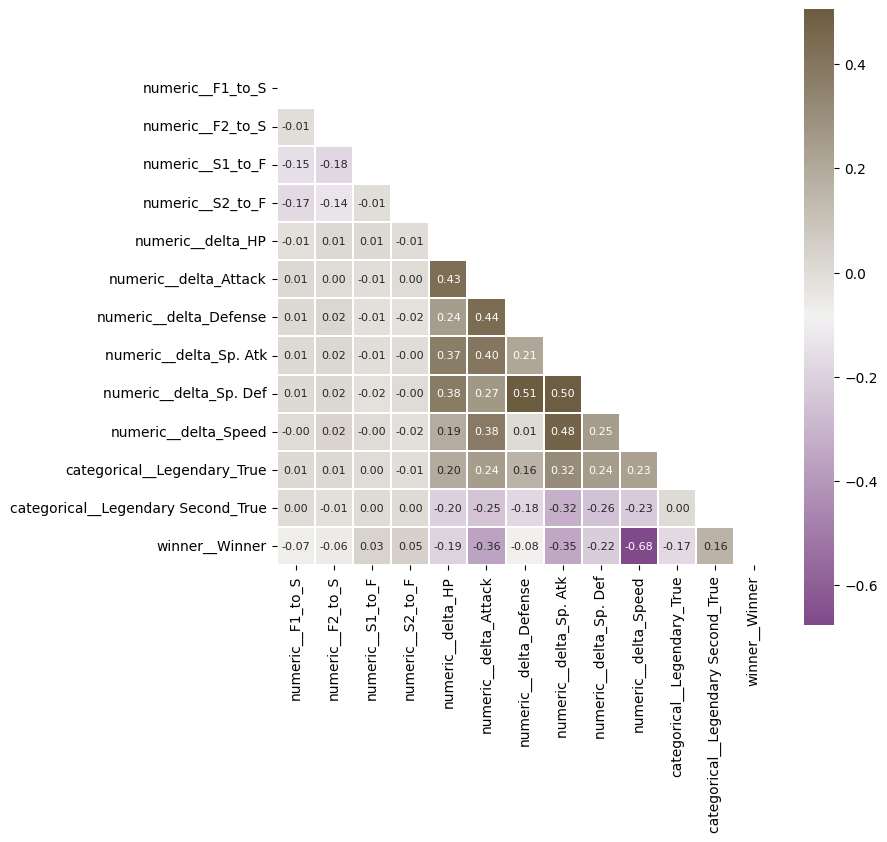

In [16]:
numerical_dataset_correlation: pd.DataFrame = dataset_encoded.corr()
# Create an upper triangular mask to avoid displaying the same data twice
mask: np.ndarray = np.zeros_like(numerical_dataset_correlation, dtype=bool)
mask[np.triu_indices_from(mask)] = True
# Plot the correlation between the variables
plt.figure(figsize=(8, 8))
sb.heatmap(numerical_dataset_correlation, mask=mask, annot=True, square=True, linewidths=0.1, cmap=cmap, fmt=".2f", annot_kws={"fontsize":8})

# Addestramento dei modelli

In [17]:
# Funzione per addestrare i modelli e calcolare il punteggio
def train_and_score_model(model, X_train, X_test, y_train, y_test):
   model.fit(X_train, y_train)
   return model.score(X_test, y_test)

# Creazione del dataset di addestramento e test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
y_train.head()

,winner__Winner
39087,0.0
30893,0.0
45278,0.0
16398,1.0
13653,1.0


In [19]:
# Modello lineare
linear_model: Pipeline = Pipeline([
    ('logistic_l1', LogisticRegression(penalty='l1', solver='liblinear'))
])
# Addestramento e valutazione del modello lineare
print(f"Linear score: {train_and_score_model(linear_model, X_train, X_test, y_train, y_test)}")

Linear score: 0.8823


c:\Users\palaz\Desktop\AISISIDF\venv\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [20]:
# Modello decision tree
decision_tree_model: Pipeline = Pipeline([
    ("tree", RandomForestClassifier(n_estimators=100, random_state=42))
])
# Addestramento e valutazione del modello decision tree
print(f"Decision tree score: {train_and_score_model(decision_tree_model, X_train, X_test, y_train, y_test)}")

c:\Users\palaz\Desktop\AISISIDF\venv\Lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Decision tree score: 0.9632


In [21]:
# Modello xgboost
xgboost_model: Pipeline = Pipeline([
   ("xgboost", XGBClassifier(eval_metric='logloss', random_state=42))
])
# Addestramento e valutazione del modello xgboost
print(f"XGB score: {train_and_score_model(xgboost_model, X_train, X_test, y_train, y_test)}")

XGB score: 0.9641


In [25]:
# Creazione di una griglia di ricerca per ottimizzare i parametri del modello XGBoost
param_grid: dict = {
   'n_estimators': [200, 300, 400],
   'max_depth': [8, 9, 10],
   'learning_rate': [0.05, 0.1, 0.15]
}
grid_xgb = GridSearchCV(XGBClassifier(eval_metric='logloss', random_state=42), param_grid, cv=3, scoring='r2')
grid_xgb.fit(X_train, y_train)
print(f"Best parameters: {grid_xgb.best_params_}")

# Creazione del modello XGBoost con i parametri ottimizzati
print(f"XGB score: {train_and_score_model(grid_xgb.best_estimator_, X_train, X_test, y_train, y_test)}")

Best parameters: {'learning_rate': 0.15, 'max_depth': 8, 'n_estimators': 200}
XGB score: 0.9654
